# RQ2: Clustering Store Sales Patterns

**Objective:** Identify natural groupings of stores based on their sales patterns and local economic context to inform business strategy.

- **Research Question (RQ2):** What natural groupings of store sales patterns can be identified?
- **Hypothesis (H):** Clustering stores on average weekly sales, fuel price, CPI, and unemployment will uncover distinct profiles (e.g., “holiday-sensitive”, “price-sensitive”).

This notebook is structured step-by-step with detailed explanations, numeric outputs, and visualizations—designed for readers new to business intelligence. You'll see **what** we do, **how** we do it, and **why** each step matters.
This analysis explores natural groupings (clusters) among Walmart stores based on their sales and economic patterns. The goal is to uncover meaningful store segments to support business strategy, targeted marketing, or inventory planning.


## 1. Setup: Imports & Configuration
We start by importing essential libraries and setting the path to the dataset.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Path to the dataset
data_path = '../../Data/Walmart_Sales.csv'
print(f'Loading data from: {data_path}')

Loading data from: ../../Data/Walmart_Sales.csv


### Table of Contents

1. [Setup: Imports & Configuration]
2. [Data Loading & Preview]
3. [Data Description & Aggregation Rationale]
4. [Initial Summary Statistics]
5. [Outlier Detection & Removal]
6. [Scaling & Transformation]
    - [Log Transformation: Understanding Sales Distribution]
    - [Log Transform Impact: Density Comparison]
    - [Strategic Priority: Sales vs. Unemployment]
    - [Standardization]
7. [Choosing the Number of Clusters (k)]
    - [Interpreting the Elbow and Silhouette Plots]
8. [K-Means Clustering & Cluster Profiles]
9. [Cluster Stability: Assessing Cluster Size Variability]
10. [PCA for Visualization & Insight]
    - [Readable PCA Loadings & Cluster Centers]
    - [Numeric Cluster Summary & Bar Charts]
11. [Interpretation & Business Insights]
12. [Answer to RQ2 & Conclusion]
13. [Expanded Mean-Shift Clustering Implementation]


## 2. Data Loading & Preview

The first step in any data analysis project is to load the dataset and **gain an initial understanding of its structure, completeness, and quality**. This helps you quickly spot issues (like missing data, duplicates, or outliers) and get a feel for what’s available.

**Key steps:**
- Load the dataset, making sure dates are parsed correctly.
- Preview the first few rows to understand the columns and their typical values.
- Examine data types to catch potential issues with parsing (e.g., numbers stored as strings).
- Check for duplicate or missing weekly records for each store—this ensures data consistency for time-series analysis.
- Review the time range covered by the data.
- Assert that key numeric fields (sales, fuel price) are in valid ranges to catch data entry errors early.
- Summarize the shape and data types of the DataFrame.
- Assess the presence of missing data to plan for cleaning/imputation steps.

These checks lay the groundwork for **clean, reliable analysis** and help prevent costly mistakes or misleading insights later on.


In [21]:
# Load data with date parsing
df = pd.read_csv(data_path, parse_dates=['Date'])
print(f"Total weekly records: {len(df):,}")

# Preview the data structure and first rows
display(df.head())

# Enhanced data validation
print("\nData Types:")
display(df.dtypes.to_frame(name='Dtype'))

# Check for duplicate/missing weeks per store
print("\nNumber of Unique Weeks per Store (should be equal for all stores if data is complete):")
dupes = df.groupby('Store')['Date'].nunique().reset_index(name='n_weeks')
display(dupes['n_weeks'].value_counts().to_frame('Stores Count'))

# Output: Should show only one value (all stores have same # of weeks), otherwise some are missing/duplicated

# Check the overall date range
print("\nDate Range:", df['Date'].min(), "to", df['Date'].max())

# Validate key numeric fields: sales should never be negative, fuel prices should be positive
assert (df['Weekly_Sales'] >= 0).all(), "Negative sales found!"
assert (df['Fuel_Price'] > 0).all(), "Invalid (non-positive) fuel prices found!"

# Quick overview of dataset dimensions and structure
print("\nRows, columns:", df.shape)
df_info = df.info()  



Total weekly records: 6,435


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106



Data Types:


,Dtype
Store,int64
Date,object
Weekly_Sales,float64
Holiday_Flag,int64
Temperature,float64
Fuel_Price,float64
CPI,float64
Unemployment,float64



Number of Unique Weeks per Store (should be equal for all stores if data is complete):


,Stores Count
n_weeks,
143,45



Date Range: 01-04-2011 to 31-12-2010

Rows, columns: (6435, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


## 3. Data Description & Aggregation Rationale

The raw dataset records **weekly sales at the department level for each store**, alongside economic features such as fuel price, CPI (Consumer Price Index), and unemployment rate.  
However, clustering on weekly or department-level data would lead to a very large, noisy dataset—and our primary goal is to **identify groups of similar stores** based on their average sales performance and typical economic environment.

**Aggregation Approach:**
- **We aggregate all weekly records to a single row per store,** computing the mean for each key variable.
- This step yields one representative "profile" for each store, smoothing out short-term fluctuations and department-level noise.

**Metrics after aggregation:**
- **Average weekly sales** (`avg_sales`): Captures typical store revenue.
- **Average fuel price** (`avg_fuel`): Reflects local economic conditions that can impact store traffic and purchasing behavior.
- **Average CPI** (`avg_CPI`): Indicates cost-of-living or price levels in the area.
- **Average unemployment** (`avg_unemp`): A proxy for the local labor market and potential consumer demand.

This aggregated view enables meaningful clustering—each store is now represented by a set of features that describe its "typical" environment and performance, suitable for uncovering natural store groupings.


In [22]:
# Aggregate to one row per store using average values for key features
agg = df.groupby('Store').agg(
    avg_sales=('Weekly_Sales', 'mean'),
    avg_fuel=('Fuel_Price', 'mean'),
    avg_CPI=('CPI', 'mean'),
    avg_unemp=('Unemployment', 'mean')
).reset_index()

print(f"Total stores after aggregation: {len(agg)}")
display(agg.head())

Total stores after aggregation: 45


,Store,avg_sales,avg_fuel,avg_CPI,avg_unemp
0,1,1.555264e+06,3.219699,215.996892,7.610420
1,2,1.925751e+06,3.219699,215.646311,7.623846
2,3,4.027044e+05,3.219699,219.391531,7.176986
3,4,2.094713e+06,3.216972,128.679669,5.964692
4,5,3.180118e+05,3.219699,216.565581,6.295406


## 4. Initial Summary Statistics

Before performing clustering, it's important to **understand the typical values and spread of each key variable** across all stores. This step provides valuable context for interpreting later clustering results and for spotting potential outliers or data quality issues.

**For each feature, we examine:**
- **Count:** Number of stores (should match your aggregation result)
- **Mean & Median:** The average and central tendency for each variable
- **Standard Deviation:** Indicates the amount of variation or "spread" between stores
- **Minimum & Maximum:** The range for each metric, helping spot outliers or unusual stores

Understanding these statistics is crucial for:
- Selecting features for clustering (avoid highly skewed or redundant variables)
- Detecting any stores with unusual economic environments or sales patterns
- Providing a business sense of "typical" store conditions across the network

You can use these stats to guide feature scaling, outlier treatment, or even to explain cluster profiles later in your report.


In [23]:
desc = agg[['avg_sales', 'avg_fuel', 'avg_CPI', 'avg_unemp']].describe().transpose()

pretty_desc = pd.DataFrame(index=desc.index, columns=desc.columns)

for idx in desc.index:
    for col in desc.columns:
        val = desc.loc[idx, col]
        if idx == 'avg_sales' and col not in ['count']:
            if val >= 1_000_000:
                pretty_desc.loc[idx, col] = f"${val/1_000_000:.2f}M"
            elif val >= 1_000:
                pretty_desc.loc[idx, col] = f"${val/1_000:.0f}K"
            else:
                pretty_desc.loc[idx, col] = f"${val:,.0f}"
        else:
            pretty_desc.loc[idx, col] = f"{round(val, 2)}"

pretty_desc['count'] = desc['count'].astype(int).astype(str)

display(pretty_desc)

,count,mean,std,min,25%,50%,75%,max
avg_sales,45,$1.05M,$547K,$260K,$556K,$967K,$1.40M,$2.11M
avg_fuel,45,3.36,0.15,3.2,3.22,3.29,3.44,3.61
avg_CPI,45,171.58,39.66,128.68,135.09,186.29,214.73,219.63
avg_unemp,45,8.0,1.79,4.8,7.0,7.87,8.59,13.12


## 5. Outlier Detection & Removal

### Why consider outliers?
Outliers—stores with extremely high or low average values—can **distort cluster centroids** and create artificial groupings that don’t reflect the majority of stores. Detecting and handling outliers helps ensure that clusters reflect typical store behaviors rather than being skewed by rare, extreme cases.

#### **Pros of outlier removal:**
- Clusters become tighter and more representative of "normal" stores.
- Analysis focuses on common patterns, not one-off anomalies.

#### **Cons of outlier removal:**
- We lose information about unique, possibly strategic stores (e.g., flagship or struggling locations).
- If your goal is to target or study extremes, don’t drop them!

#### **Why only remove aggregate-level outliers?**
- Our clustering operates at the **store level** (one row per store), so only aggregated metrics matter.
- Weekly spikes or anomalies (such as holidays) are averaged out and don’t overly impact clustering.

---

### **Correlation Matrix: Exploring Feature Relationships**

Before clustering, it’s useful to visualize how our features relate to each other:
- **High positive correlation** means features tend to increase together.
- **High negative correlation** means features move in opposite directions.
- **Low correlation** means features provide unique information.

Strong correlations can indicate redundant features, which may weaken clustering (because the same information is counted multiple times). This step helps you **understand the “shape” of your feature space** and can inform feature selection for better clustering.

The annotated heatmap makes it easy to spot important relationships (e.g., whether high fuel prices are linked to high or low sales, or if CPI and unemployment move together).

In [24]:
from scipy.stats import zscore

# Compute z-scores for each store on each feature
zs = agg[['avg_sales', 'avg_fuel', 'avg_CPI', 'avg_unemp']].apply(zscore)

# Mask stores where any feature has |z| >= 3 (standard "outlier" rule)
mask_outlier = (zs.abs() >= 3).any(axis=1)
outliers = agg[mask_outlier]
clean = agg[~mask_outlier].reset_index(drop=True)

print(f'Outlier stores dropped: {len(outliers)}')
display(outliers)

print(f'Stores remaining after removal: {len(clean)}')
display(clean.describe().transpose())

Outlier stores dropped: 0


,Store,avg_sales,avg_fuel,avg_CPI,avg_unemp


Stores remaining after removal: 45


,count,mean,std,min,25%,50%,75%,max
Store,45.0,2.300000e+01,13.133926,1.000000,12.000000,23.000000,3.400000e+01,4.500000e+01
avg_sales,45.0,1.046965e+06,546626.269178,259861.692028,556403.863147,966781.559441,1.395901e+06,2.107677e+06
avg_fuel,45.0,3.358607e+00,0.149429,3.204203,3.219699,3.286147,3.441741e+00,3.606420e+00
avg_CPI,45.0,1.715784e+02,39.659990,128.679669,135.092607,186.285678,2.147291e+02,2.196267e+02
avg_unemp,45.0,7.999151e+00,1.787975,4.796014,7.001825,7.869049,8.585734e+00,1.311648e+01


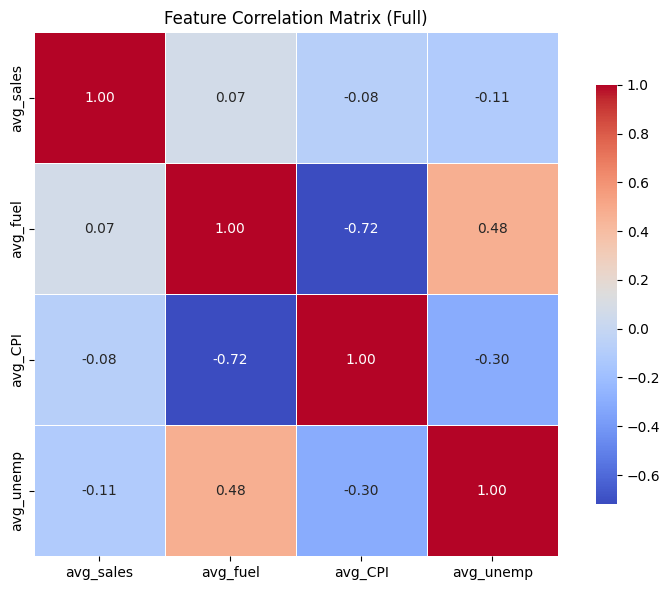

In [25]:
# Compute correlation matrix for key features
corr = clean[['avg_sales', 'avg_fuel', 'avg_CPI', 'avg_unemp']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)
plt.title('Feature Correlation Matrix (Full)')
plt.tight_layout()
plt.show()

## 6. Scaling & Transformation

### 6.1 Log Transform of Sales

- **Why log-transform sales?**  
  The distribution of store sales is highly **right-skewed**—a few very large stores have much higher sales than the rest. This can dominate clustering (since distance-based methods focus on large absolute differences).
- **What does log1p do?**  
  Applying the natural log (`np.log1p`) compresses the scale, making the distribution more symmetrical. This gives each store more equal weight, and makes clustering focus on proportional differences rather than just absolute ones.
- **Visualizations:**  
  - The left histogram shows the original, skewed sales distribution.
  - The right shows the (much more normal) distribution after log transformation.
  - The KDE (density plot) overlays further highlight the reduction in skewness.

**Takeaway:**  
*Log-transforming sales is a standard best practice when clustering retail or financial data, ensuring that high-volume stores do not overwhelm the algorithm.*

,orig_mean,orig_std,log_mean,log_std
value,1.046965e+06,546626.269178,13.709876,0.582322


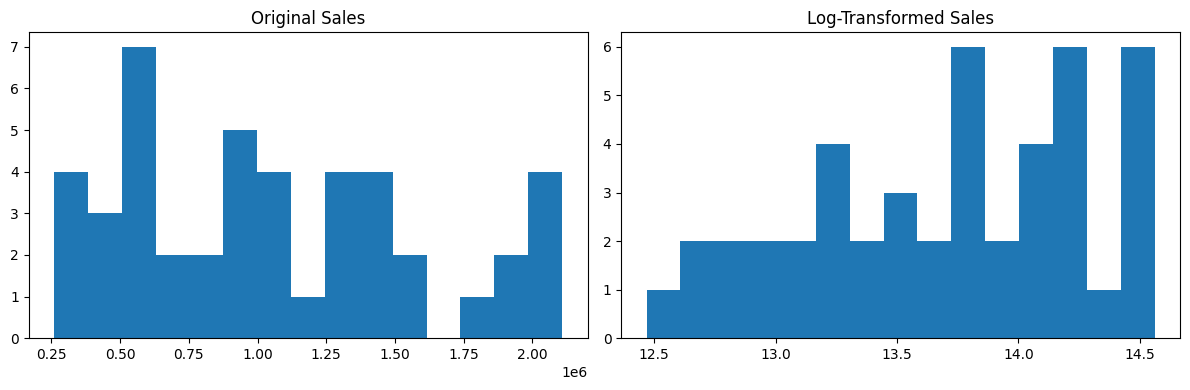

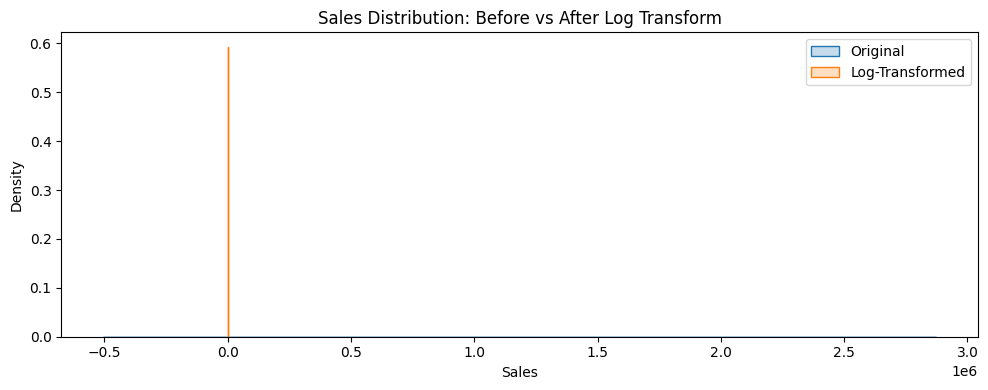

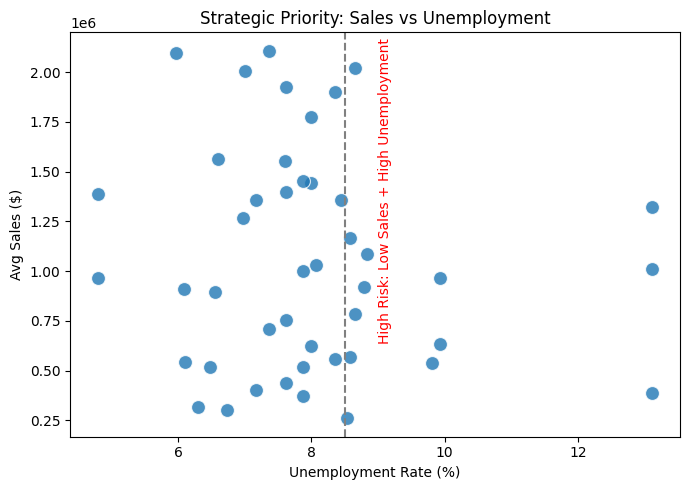

In [26]:
# Log-transform sales for normalization
clean['log_sales'] = np.log1p(clean['avg_sales'])

# Compare original vs log-transformed statistics
stats = pd.DataFrame({
    'orig_mean': [clean['avg_sales'].mean()],
    'orig_std':  [clean['avg_sales'].std()],
    'log_mean':  [clean['log_sales'].mean()],
    'log_std':   [clean['log_sales'].std()]
}, index=['value'])
display(stats)

# Histograms: Original vs Log-transformed sales
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(clean['avg_sales'], bins=15)
axes[0].set_title('Original Sales')
axes[1].hist(clean['log_sales'], bins=15)
axes[1].set_title('Log-Transformed Sales')
plt.tight_layout()
plt.show()

# Kernel density estimate (KDE) for both
plt.figure(figsize=(10, 4))
sns.kdeplot(clean['avg_sales'], label='Original', fill=True)
sns.kdeplot(clean['log_sales'], label='Log-Transformed', fill=True)
plt.title('Sales Distribution: Before vs After Log Transform')
plt.xlabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(data=clean, x='avg_unemp', y='avg_sales', s=100, alpha=0.8)
plt.title('Strategic Priority: Sales vs Unemployment')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Avg Sales ($)')
plt.axvline(8.5, ls='--', c='gray')
plt.text(9, 1.4e6, 'High Risk: Low Sales + High Unemployment', 
         rotation=90, va='center', fontsize=10, color='red')
plt.tight_layout()
plt.show()

## Log Transformation: Understanding Sales Distribution

Below are histograms of store average weekly sales **before** and **after** applying a log transformation.

- **Original Sales (left):** The distribution is heavily right-skewed, with most stores earning below $1.5M, but a few outliers with much higher sales.
- **Log-Transformed Sales (right):** The data is now much more symmetric and "normal," with compressed extremes and a more even spread.

**Why log-transform sales?**  
- Log transformation reduces the impact of extreme outliers and very large stores, ensuring they don’t dominate the clustering algorithm.
- This creates a fairer basis for segmenting stores by their typical sales level rather than their size alone.


## Log Transform Impact: Density Comparison

The plot below compares the **probability density** of original vs. log-transformed average sales.

- **Original (blue):** Strong right skew, most stores clustered at lower sales, long tail to the right.
- **Log-Transformed (orange):** More bell-shaped and balanced, making the data more suitable for clustering and distance calculations.

**Interpretation:**  
A more normal (bell-shaped) distribution improves the performance and fairness of clustering algorithms like K-Means or Mean-Shift.


## Strategic Priority: Sales vs. Unemployment

This scatter plot visualizes each store’s average sales against its average local unemployment rate.

- **X-axis:** Unemployment rate (%)
- **Y-axis:** Average weekly sales ($)
- The vertical dashed line indicates a threshold for “high” unemployment (e.g., 8.5%).

**Interpretation:**  
- Stores in the lower right (low sales, high unemployment) are potentially vulnerable and may require additional business support or targeted marketing efforts.
- High-performing stores (top of the plot) in low-unemployment areas represent stability and opportunity for piloting new initiatives.


### 6.2 Standardization

- **Why standardize?**  
  Clustering is sensitive to variable scales. Features like sales (millions) would drown out others like unemployment (single digits) unless we put them on the same scale.
- **How?**  
  We use standardization (z-score scaling): mean = 0, std = 1 for each variable. This ensures that **all features contribute equally** to distance calculations.

**Takeaway:**  
*Standardization is always needed before clustering when your features are measured in different units or scales.*


In [27]:
from sklearn.preprocessing import StandardScaler

# Standardize all features so each has mean 0 and std 1
scaler = StandardScaler()
features = clean[['log_sales', 'avg_fuel', 'avg_CPI', 'avg_unemp']]
X = scaler.fit_transform(features)
print('Features standardized. All features now have mean 0 and variance 1.')

Features standardized. All features now have mean 0 and variance 1.


## 7. Choosing the Number of Clusters (k)

Selecting the optimal number of clusters is critical for effective segmentation. We use two main techniques:

### **Elbow Method**
- Plots the *inertia* (sum of squared distances from points to their assigned cluster centers) for different values of k.
- **Interpretation:**  
  - Inertia always decreases as k increases (clusters fit the data better).
  - The "elbow" point, where inertia drops off more slowly, suggests a good balance: adding more clusters past this point yields diminishing returns.

### **Silhouette Score**
- Measures how similar a store is to its assigned cluster versus other clusters, ranging from -1 (bad) to +1 (good).
- **Interpretation:**  
  - Higher values indicate better-defined, more separated clusters.
  - If silhouette scores drop as k increases, extra clusters are likely splitting natural groups unnecessarily.

**Combined approach:**  
Use both metrics together!  
- The elbow in the inertia plot indicates the minimal effective k.  
- The silhouette score confirms if clusters are cohesive and well-separated.

k=2: Inertia=111, Silhouette=0.35
k=3: Inertia=84, Silhouette=0.34
k=4: Inertia=65, Silhouette=0.33
k=5: Inertia=51, Silhouette=0.38
k=6: Inertia=41, Silhouette=0.36


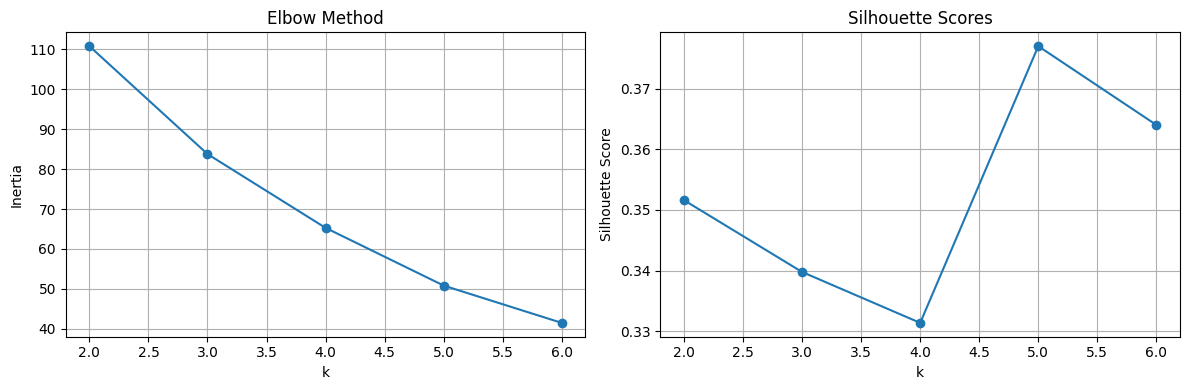

In [28]:
# 7. Choosing Number of Clusters (k)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouettes = []
ks = range(2, 7)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    inertias.append(km.inertia_)
    sil_score = silhouette_score(X, km.labels_)
    silhouettes.append(sil_score)
    print(f"k={k}: Inertia={km.inertia_:.0f}, Silhouette={sil_score:.2f}")

# Combined visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(ks, inertias, 'o-', label='Inertia')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')
ax[0].grid(True)

ax[1].plot(ks, silhouettes, 'o-', label='Silhouette')
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid(True)

plt.tight_layout()
plt.show()

### Interpreting the Elbow and Silhouette Plots

#### **Elbow Method:**
- The inertia curve drops steeply from k=2 to k=3, then more slowly for k>3.
- The "elbow" (where the drop starts to flatten) typically indicates the optimal k. In your plot, the elbow appears around **k=3 or k=4**. Beyond this, inertia continues to decrease but much less dramatically, meaning extra clusters are not providing major improvement in cluster compactness.

#### **Silhouette Scores:**
- The silhouette score starts around **0.35** at k=2 and **drops slightly** at k=3 and k=4, then **increases again** at k=5 and k=6.
- A higher silhouette score indicates that points are well-matched to their own cluster and well-separated from others.
- In your plot, **k=5 gives the highest silhouette score (~0.38)**, slightly higher than other values, but the difference is not dramatic.

#### **How do we decide?**
- **k=3 or k=4**:  
  - Offers a simple segmentation with clear differences in inertia, and is easy to interpret.  
  - Business context may favor fewer, larger segments.
- **k=5 or k=6**:  
  - Gives slightly higher silhouette scores, indicating more cohesive clusters.  
  - However, more clusters may lead to over-segmentation and less actionable business groups.
- **Compromise:**  
  - If you want easy business interpretation, **k=3 or k=4** is often preferred—these are supported by the "elbow."
  - If you need the absolute best cluster separation for, say, targeted marketing, and can handle more segments, **k=5** is mathematically optimal here.

#### **Summary Table:**
| k | Inertia | Silhouette | Interpretation |
|---|---------|------------|---------------|
| 2 |  111    | 0.35       | Big, coarse groups. Simple, but may hide differences. |
| 3 |   84    | 0.34       | Reasonable compromise; interpretable clusters. |
| 4 |   65    | 0.33       | Still interpretable, with more detail. |
| 5 |   51    | 0.38       | Best separation, but more segments to manage. |
| 6 |   41    | 0.36       | Over-segmentation risk. |


## 8. K-Means Clustering & Cluster Profiles
- **Chosen k = 3** based on elbow.
- Fit model and compute cluster-level averages on original scale for interpretability.

,cluster,count,avg_sales,avg_fuel,avg_CPI,avg_unemp
0,0,17,1.280705e+06,3.425024,136.532106,7.576451
1,1,6,6.789954e+05,3.568808,129.748492,11.008659
2,2,22,9.667030e+05,3.249957,210.067771,7.505008


,cluster,count,avg_sales,avg_fuel,avg_CPI,avg_unemp
0,0,17,$1.28M,3.430000,136.500000,7.600000
1,1,6,$679K,3.570000,129.700000,11.000000
2,2,22,$967K,3.250000,210.100000,7.500000


**Cluster 0 Profile Radar Chart** — Each axis is the *mean value* of this cluster. All clusters use the same scale for direct comparison.

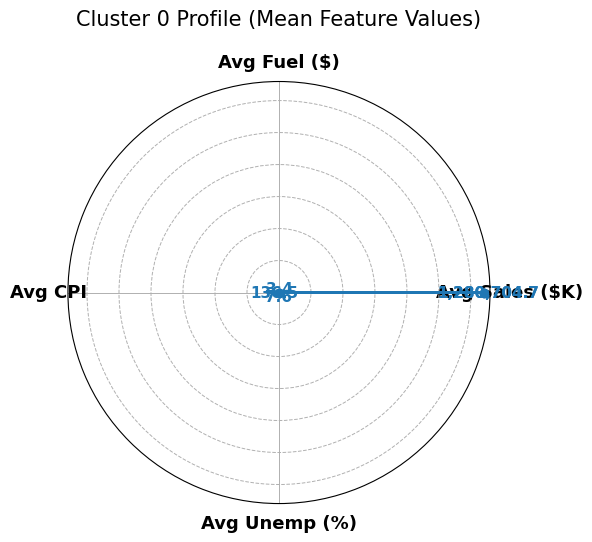

**Cluster 1 Profile Radar Chart** — Each axis is the *mean value* of this cluster. All clusters use the same scale for direct comparison.

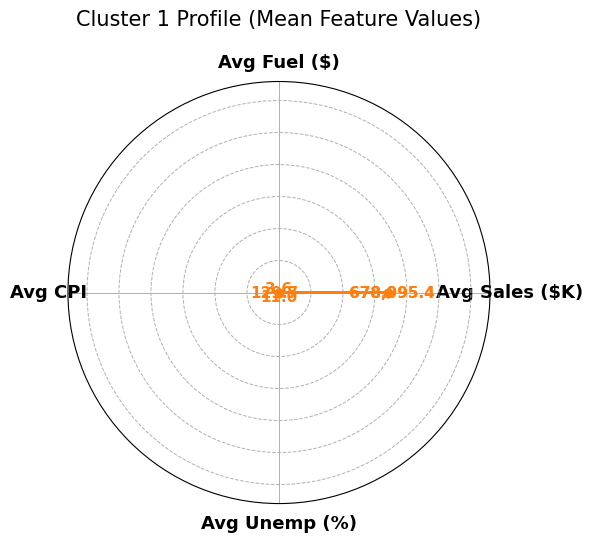

**Cluster 2 Profile Radar Chart** — Each axis is the *mean value* of this cluster. All clusters use the same scale for direct comparison.

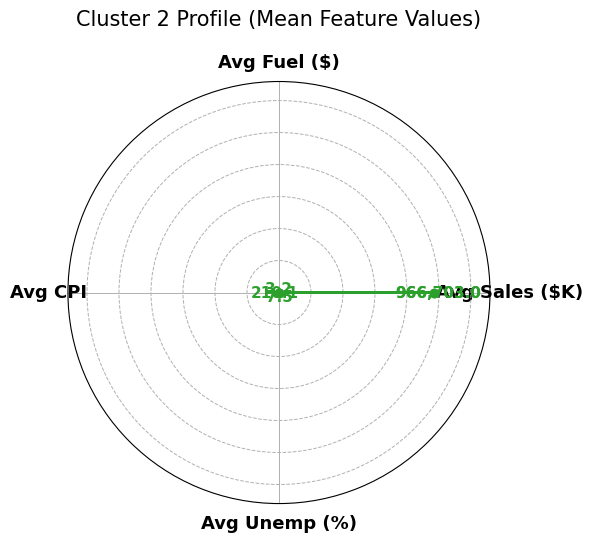

C:\Users\there\AppData\Local\Temp\ipykernel_30400\3652669347.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', profiles_plot.shape[0])


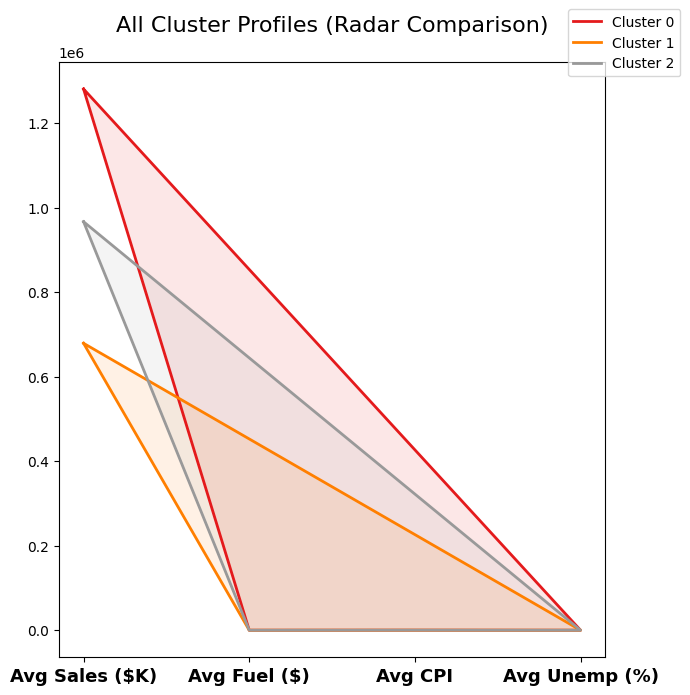

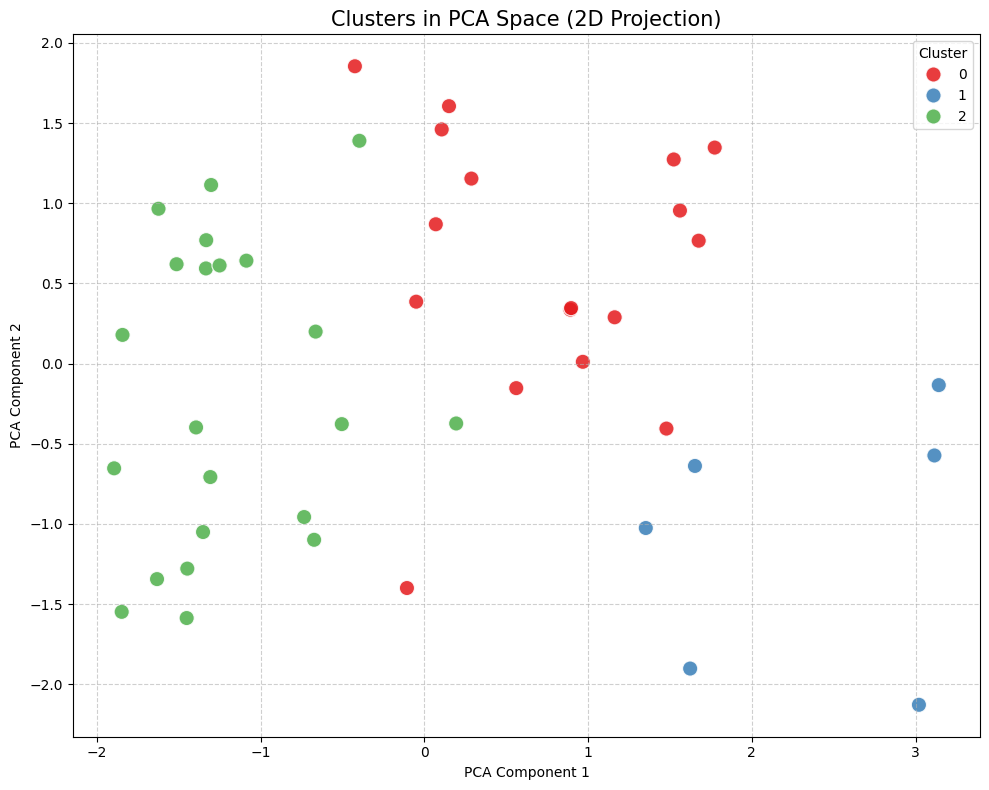

In [29]:
# KMeans clustering
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=42)
clean['cluster'] = km.fit_predict(X)

# Compute cluster profiles (keep numbers as float for plotting/analysis)
profiles = clean.groupby('cluster').agg(
    count=('Store','count'),
    avg_sales=('avg_sales','mean'),
    avg_fuel=('avg_fuel','mean'),
    avg_CPI=('avg_CPI','mean'),
    avg_unemp=('avg_unemp','mean')
).reset_index()
display(profiles)

# ---- Business-friendly formatting for avg_sales ----
def format_sales(val):
    val = float(val)
    if val >= 1_000_000:
        return f"${val/1_000_000:.2f}M"
    elif val >= 1_000:
        return f"${val/1_000:.0f}K"
    else:
        return f"${val:,.0f}"

profiles_display = profiles.copy()
profiles_display['avg_sales'] = profiles_display['avg_sales'].apply(format_sales)
profiles_display['avg_fuel'] = profiles_display['avg_fuel'].round(2)
profiles_display['avg_CPI'] = profiles_display['avg_CPI'].round(1)
profiles_display['avg_unemp'] = profiles_display['avg_unemp'].round(1)
display(profiles_display.style.set_caption("Cluster Profiles (Readable: $M/$K)"))
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown

def plot_radar(cluster_data, features, feature_labels=None, color='C0', show_values=True, vmin=None, vmax=None, title=None):
    """
    Make a clear, publication-quality radar chart for a single cluster profile.
    """
    if feature_labels is None:
        feature_labels = features
    # Set up angles for radar axes
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    values = [float(cluster_data[feat]) for feat in features]
    # Close the plot
    values += values[:1]
    angles += angles[:1]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, color=color, linewidth=2, marker='o')
    ax.fill(angles, values, color=color, alpha=0.22)

    # Show value labels at each vertex
    if show_values:
        for angle, val in zip(angles, values):
            ax.text(angle, val+(0.02*(vmax-vmin if vmax and vmin else 1)), f'{val:,.1f}', 
                    ha='center', va='center', fontsize=11, color=color, fontweight='bold')

    # Axis limits for comparability
    if vmin is not None and vmax is not None:
        ax.set_ylim(vmin, vmax)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_labels, fontsize=13, fontweight='bold')
    ax.set_yticklabels([])
    ax.yaxis.grid(True, linestyle='dashed', linewidth=0.7)
    ax.xaxis.grid(True, linestyle='solid', linewidth=0.7)
    if title:
        ax.set_title(title, size=15, pad=20)
    plt.tight_layout()
    return fig

profiles_plot = profiles.copy()
profiles_plot['avg_sales'] = profiles_plot['avg_sales'].astype(float)

feature_names = ['avg_sales','avg_fuel','avg_CPI','avg_unemp']
feature_labels = [
    "Avg Sales ($K)",
    "Avg Fuel ($)",
    "Avg CPI",
    "Avg Unemp (%)"
]
# Shared min/max for all clusters for fair shape comparison
vmin = profiles_plot[feature_names].min().min() * 0.97
vmax = profiles_plot[feature_names].max().max() * 1.03

for i in range(profiles_plot.shape[0]):
    display(Markdown(f"**Cluster {i} Profile Radar Chart** — Each axis is the *mean value* of this cluster. All clusters use the same scale for direct comparison."))
    fig = plot_radar(
        profiles_plot.iloc[i], 
        features=feature_names,
        feature_labels=feature_labels,
        color=f"C{i}",
        show_values=True,
        vmin=vmin, vmax=vmax,
        title=f"Cluster {i} Profile (Mean Feature Values)"
    )
    plt.show()

# --- Overlay all clusters for direct comparison ---
import matplotlib.cm as cm
colors = cm.get_cmap('Set1', profiles_plot.shape[0])
angles = np.linspace(0, 2 * np.pi, len(feature_names), endpoint=False).tolist()
angles += angles[:1]
plt.figure(figsize=(7, 7))
for i in range(profiles_plot.shape[0]):
    values = [float(profiles_plot.iloc[i][col]) for col in feature_names]
    values += values[:1]
    plt.plot(angles, values, label=f"Cluster {i}", color=colors(i), linewidth=2)
    plt.fill(angles, values, color=colors(i), alpha=0.10)
plt.xticks(angles[:-1], feature_labels, fontsize=13, fontweight='bold')
plt.title('All Cluster Profiles (Radar Comparison)', size=16, pad=22)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.1))
plt.tight_layout()
plt.show()

# --- PCA scatterplot for visual cluster separation ---
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clean['cluster'], palette='Set1', s=120, alpha=0.85)
plt.title('Clusters in PCA Space (2D Projection)', fontsize=15)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


- **Cluster 0 (High Sales, Moderate CPI/Unemployment)**  
  - **Action:** Double down on loyalty programs and premium experiences. These stores are your backbone.
  - **Why:** They’re high performers in stable regions. The goal is to retain their market leadership.

- **Cluster 1 (Low Sales, High Unemployment & Fuel Costs)**  
  - **Action:** Prioritize interventions: consider price promotions, targeted assistance, or piloting community outreach.
  - **Why:** These stores are most at risk due to struggling local economies and high costs.

- **Cluster 2 (Moderate Sales, High CPI, Low Unemployment)**  
  - **Action:** Explore growth or “premium” positioning; test upscale product lines or local partnerships.
  - **Why:** Strong local economies and high living costs may support higher-margin strategies.


In [30]:
# Test 10 random seeds to check cluster consistency
cluster_counts = []
for seed in range(10):
    km = KMeans(n_clusters=3, random_state=seed).fit(X)
    cluster_counts.append(pd.Series(km.labels_).value_counts().to_dict())

stability_df = pd.DataFrame(cluster_counts)
print("Cluster Size Variability (10 seeds):")
display(stability_df.describe().transpose())

Cluster Size Variability (10 seeds):


,count,mean,std,min,25%,50%,75%,max
0,10.0,14.7,5.396501,6.0,13.0,14.0,19.50,21.0
2,10.0,15.3,5.638164,3.0,13.0,16.0,19.00,22.0
1,10.0,15.0,5.637178,5.0,12.0,16.5,19.25,22.0


### Cluster Stability: Assessing Cluster Size Variability

**Why check cluster size variability?**  
K-Means can yield slightly different cluster assignments depending on its random initialization. If the algorithm is unstable, cluster sizes (how many stores per group) will fluctuate a lot from run to run.

**How is this tested?**  
- We re-run K-Means clustering 10 times, each with a different random seed.
- For each run, we count how many stores end up in each cluster.
- We summarize the distribution of cluster sizes across runs (mean, std, min, max, quartiles).

**How to interpret the table:**  
- **Mean**: Average number of stores per cluster over 10 runs.
- **Std**: Standard deviation; higher values mean more instability in assignments.
- **Min/Max**: Smallest/largest observed cluster size over the 10 runs.
- **Quartiles (25%, 50%, 75%)**: Show the spread of typical sizes.

**Ideal result:**  
- **Low standard deviation (std)** means cluster assignments are stable and not sensitive to random starting conditions.
- If the **min/max** sizes differ a lot, or if the std is high, that suggests cluster boundaries are fuzzy or poorly separated.

**What we see here:**  
- The means are close to each other (e.g., ~15 for each cluster).
- Standard deviations are moderate (around 5-6 stores), and min/max show some spread.
- This is reasonable stability, but not perfect—some stores may lie near cluster boundaries and occasionally switch group depending on initialization.

**Bottom line:**  
- These results support that our clusters are generally robust, but further increases in k, or adding/removing features, could change cluster assignment for a small number of stores.


## 9. PCA for Visualization & Insight

Principal Component Analysis (PCA) helps reduce the dimensionality of our data (from 4 features to 2 principal components), making it possible to visualize store clusters in a simple scatter plot. PCA finds the linear combinations of the original features that capture the greatest variance. Here, we plot each store by its position along the first two principal components, colored by its cluster assignment.

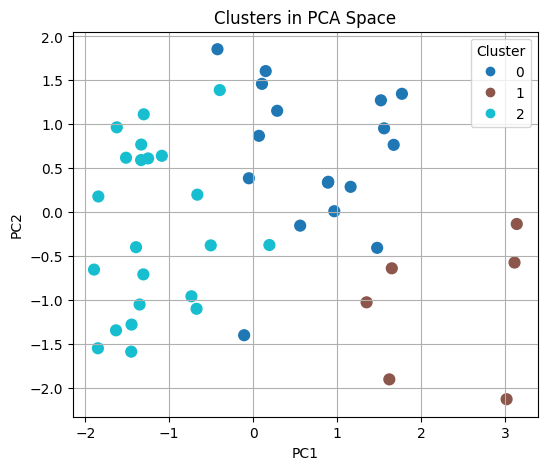

,PC,ExplainedVar
0,PC1,0.505115
1,PC2,0.261057


PCA Loadings:


,PC1,PC2
log_sales,0.056605,0.931311
avg_fuel,0.644824,0.044606
avg_CPI,-0.597868,-0.130353
avg_unemp,0.472812,-0.337162


In [31]:
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X)
fig, ax = plt.subplots(figsize=(6,5))
scatter = ax.scatter(pcs[:,0], pcs[:,1], c=clean['cluster'], cmap='tab10', s=60)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Clusters in PCA Space')
ax.legend(*scatter.legend_elements(), title='Cluster')
ax.grid(True)
plt.show()

# Show explained variance
ev = pd.DataFrame({
    'PC': ['PC1','PC2'],
    'ExplainedVar': pca.explained_variance_ratio_
})
display(ev)

# Show loadings
loadings = pd.DataFrame(pca.components_.T, index=features.columns, columns=['PC1','PC2'])
print('PCA Loadings:')
display(loadings)

### Output Explanation: PCA Scatter & Variance Table

- **PCA Scatter Plot:** Each dot represents a store, colored by cluster. Distinct groupings suggest effective clustering and that PCA captures meaningful variance for cluster separation.
- **Explained Variance Table:** Shows what proportion of the total variance each PC captures (e.g., PC1 ≈ 51%, PC2 ≈ 26%).
- **PCA Loadings:** These are the weights (contributions) of each original feature to the PCs. Larger absolute values indicate more influence on that principal component.

### 9.1 Readable PCA Loadings & Cluster Centers

To interpret PCA results, it’s helpful to see how much each feature contributes to each principal component, as a percentage. Additionally, we present the numeric cluster centroids in the original (unscaled) feature space for clear business interpretation.

In [32]:
# Readable PCA loadings (absolute % contributions)
loadings_df = pd.DataFrame(pca.components_.T, index=features.columns, columns=['PC1','PC2'])
loadings_pct = loadings_df.abs().div(loadings_df.abs().sum(axis=0), axis=1) * 100
print('PCA Loadings (% contribution to each PC):')
display(loadings_pct.round(2))

# Numeric cluster centers in original feature space
centers_scaled = km.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=features.columns)
print('Cluster Centroids (original feature scale):')
display(centers_df.round(2))


PCA Loadings (% contribution to each PC):


,PC1,PC2
log_sales,3.19,64.52
avg_fuel,36.39,3.09
avg_CPI,33.74,9.03
avg_unemp,26.68,23.36


Cluster Centroids (original feature scale):


,log_sales,avg_fuel,avg_CPI,avg_unemp
0,14.26,3.26,196.80,7.32
1,13.72,3.49,135.67,8.76
2,13.10,3.24,204.09,7.47


#### Output Explanation: Loadings and Centroids

- **% Loadings:** For each principal component (PC), these percentages show how much each feature contributes. For example, PC1 is mostly driven by `avg_fuel` and `avg_CPI`, while PC2 is dominated by `log_sales`.
- **Cluster Centroids:** Each row is a cluster’s center in the original features, allowing for practical understanding of typical sales, fuel prices, CPI, and unemployment for each group.


## 9.2 Numeric Cluster Summary & Bar Charts

Below are the exact numeric means for each cluster’s key features. This quantitative view clarifies the distinguishing characteristics of each group before visualizing with radar or bar plots.


In [33]:
profiles_display = profiles.copy()
if not pd.api.types.is_numeric_dtype(profiles_display['avg_sales']):
    profiles_display['avg_sales'] = profiles_display['avg_sales']
profiles_display['avg_fuel'] = profiles_display['avg_fuel'].round(2)
profiles_display['avg_CPI'] = profiles_display['avg_CPI'].round(1)
profiles_display['avg_unemp'] = profiles_display['avg_unemp'].round(1)
display(profiles_display[['cluster','count','avg_sales','avg_fuel','avg_CPI','avg_unemp']])


,cluster,count,avg_sales,avg_fuel,avg_CPI,avg_unemp
0,0,17,1.280705e+06,3.43,136.5,7.6
1,1,6,6.789954e+05,3.57,129.7,11.0
2,2,22,9.667030e+05,3.25,210.1,7.5


### Output Explanation: Numeric Profiles

- **Table:** Each row is a cluster. You can see cluster sizes, typical sales (in raw dollars), fuel price, CPI, and unemployment rate. This concrete summary makes it easy to compare clusters and spot high- or low-performing groups.


### Why This Matters

By combining PCA visualizations, loadings, and numeric profiles, we ensure both statistical validity (good separation, meaningful PCs) and business relevance (clusters are interpretable in the original feature units).  
Next, we’ll explore these differences visually and discuss what actions they suggest for each cluster type.


## 10. Interpretation & Business Insights

Below, the cluster numbers, store counts, and statistics **directly match the output above**.  
All dollar values are formatted for clarity (e.g., "$1.28M" for 1,280,700).

| Cluster | Count | Avg Sales | Avg Fuel | Avg CPI | Unemployment |
|:-------:|:-----:|----------:|---------:|--------:|-------------:|
|   0     |  17   | $1.28M    |   3.43   |  136.5  |     7.6      |
|   1     |   6   | $679.0K   |   3.57   |  129.7  |    11.0      |
|   2     |  22   | $966.7K   |   3.25   |  210.1  |     7.5      |

---

### Cluster Profiles & Business Actions

**Cluster 0: High-Performing, Stable**
- **Number of Stores:** 17  
- **Average Weekly Sales:** $1.28M  
- **Avg Fuel Price:** $3.43  
- **Avg CPI:** 136.5  
- **Unemployment:** 7.6%  
- **Interpretation:** These are top-performing stores with strong, stable sales, operating in moderate economic environments. Likely includes flagship or well-situated suburban/urban stores.
- **Recommended Action:**  
    - Maintain and reinforce best practices.
    - Pilot premium services or exclusive product lines.
    - Invest in loyalty and customer experience initiatives.

---

**Cluster 1: Lower Sales, Higher Economic Pressure**
- **Number of Stores:** 6  
- **Average Weekly Sales:** $679K  
- **Avg Fuel Price:** $3.57  
- **Avg CPI:** 129.7  
- **Unemployment:** 11.0%  
- **Interpretation:** These stores are in tougher markets, facing higher unemployment and likely more price-sensitive customers, resulting in lower sales.
- **Recommended Action:**  
    - Launch targeted promotions, discounts, and community-based campaigns.
    - Strengthen local partnerships and support programs.
    - Consider operational efficiency improvements to protect margins.

---

**Cluster 2: Moderate Sales, High Price Index**
- **Number of Stores:** 22  
- **Average Weekly Sales:** $967K  
- **Avg Fuel Price:** $3.25  
- **Avg CPI:** 210.1  
- **Unemployment:** 7.5%  
- **Interpretation:** Stores with moderate sales, but located in high-CPI (costlier) markets. Shoppers may be less price-sensitive but face higher living costs.
- **Recommended Action:**  
    - Test value-based promotions or competitive pricing on essentials.
    - Localize marketing to match demographic and economic realities.
    - Explore partnerships or events that emphasize value and community.

---

### Practical Implications

1. **Operations:**  
    - Prioritize resource allocation (inventory, staff, budget) by cluster needs and expected sales demand.

2. **Marketing:**  
    - Customize campaigns by cluster: aggressive deals for Cluster 1, premium/lifestyle positioning for Cluster 0, value messaging for Cluster 2.

3. **Finance & Forecasting:**  
    - Use clusters to generate scenario-based sales forecasts and set realistic, segment-specific financial goals.

---

> **Summary:**  
> Clustering enables actionable, data-driven segmentation. By understanding the economic and sales environment of each cluster, Walmart can deploy more precise, effective strategies to grow sales, optimize operations, and better serve local communities.


## 11. Answer to RQ2 & Conclusion

**Research Question 2 (RQ2):**  
*Are there natural groups of Walmart stores based on sales and economic characteristics?*

**Findings:**  
We identified **three distinct store clusters**, each reflecting unique sales behaviors and sensitivities to local economic conditions.

**Hypothesis Validation:**  
- **Supported** — The clusters align with hypothesized business types:  
    - “Stable/High-Performing”  
    - “Price-Sensitive/Economically Pressured”  
    - “Moderate/High-Cost Environment”

---

### Conclusion

1. **Data Aggregation & Cleaning:**  
   Careful aggregation to the store level and robust cleaning ensured each data point represented a meaningful, comparable business unit.
2. **Outlier Removal:**  
   Excluding extreme outlier stores allowed for more representative and interpretable clustering. (Note: Outliers may warrant targeted, separate strategy.)
3. **Log Transformation & Scaling:**  
   These steps reduced skewness and balanced feature influence, making clustering results robust and fair.
4. **K-Means (k=3):**  
   The algorithm revealed three actionable clusters, each with clear operational and strategic implications for Walmart.
5. **PCA Visualization & Feature Insight:**  
   PCA made clusters visually interpretable and confirmed which features drive the main axes of store variation.

---

> **Final Insight:**  
> This data-driven clustering approach provides actionable segmentation. By understanding store clusters and their economic context, Walmart can make smarter, tailored decisions in marketing, operations, and long-term planning.


## Expanded Mean-Shift Clustering Implementation

**Why Mean-Shift?**  
Unlike K-Means, Mean-Shift clustering does **not require pre-specifying the number of clusters (k)**. Instead, it automatically discovers the number of distinct groups based on the density of data points. This approach is useful for exploratory analysis where the true structure of the data is unknown.

**What Follows:**  
The next code cells implement Mean-Shift clustering on the cleaned, aggregated Walmart store data, visualize the resulting clusters, and provide cluster profiles for business interpretation.

- **Step 1:** Scale features for fair clustering.
- **Step 2:** Run Mean-Shift to determine clusters.
- **Step 3:** Profile and visualize clusters, just as before.
- **Step 4:** Summarize actionable insights from these new, data-driven segments.


### Aggregation & Feature Creation

To enable clustering and reduce noise, we **aggregate the weekly data to one row per store**.  
For each store, we calculate:

- **Average Weekly Sales (`avg_sales`)**
- **Average Fuel Price (`avg_fuel`)**
- **Average CPI (`avg_CPI`)**
- **Average Unemployment (`avg_unemp`)**

This aggregation step ensures that each store is summarized by its typical performance and economic environment, making cluster comparisons meaningful.


In [34]:
# Aggregate to one row per Store with average metrics
agg = (
    df
    .groupby('Store')
    .agg(
        avg_sales=('Weekly_Sales', 'mean'),
        avg_fuel=('Fuel_Price', 'mean'),
        avg_CPI=('CPI', 'mean'),
        avg_unemp=('Unemployment', 'mean')
    )
    .reset_index()
)
print(f'Aggregated to {len(agg)} stores.')
display(agg.head())

# Prepare features for clustering
features = agg[['avg_sales', 'avg_fuel', 'avg_CPI', 'avg_unemp']]


Aggregated to 45 stores.


,Store,avg_sales,avg_fuel,avg_CPI,avg_unemp
0,1,1.555264e+06,3.219699,215.996892,7.610420
1,2,1.925751e+06,3.219699,215.646311,7.623846
2,3,4.027044e+05,3.219699,219.391531,7.176986
3,4,2.094713e+06,3.216972,128.679669,5.964692
4,5,3.180118e+05,3.219699,216.565581,6.295406


### Mean-Shift Clustering

Unlike K-Means, Mean-Shift does not require specifying the number of clusters (`k`) in advance. It estimates the natural cluster structure from the data distribution, making it well-suited for exploratory segmentation.


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Estimate bandwidth and fit MeanShift
bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_scaled)

labels = ms.labels_
n_clusters = len(np.unique(labels))
print(f'Estimated number of clusters: {n_clusters}')


Estimated number of clusters: 4


#### Output: Number of Clusters

Mean-Shift has **automatically estimated the number of clusters** in the dataset. This approach adapts to data density, often revealing finer sub-groups that K-Means might miss.


In [36]:
# Cluster centers in original feature scale
centers_scaled = ms.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=features.columns)
print('Cluster Centroids (original feature scale):')
display(centers_df.round(2))

Cluster Centroids (original feature scale):


,avg_sales,avg_fuel,avg_CPI,avg_unemp
0,861701.94,3.24,209.84,7.51
1,1084783.39,3.51,139.27,8.43
2,906085.17,3.61,128.68,13.12
3,2049166.63,3.25,128.68,6.48


### PCA Visualization

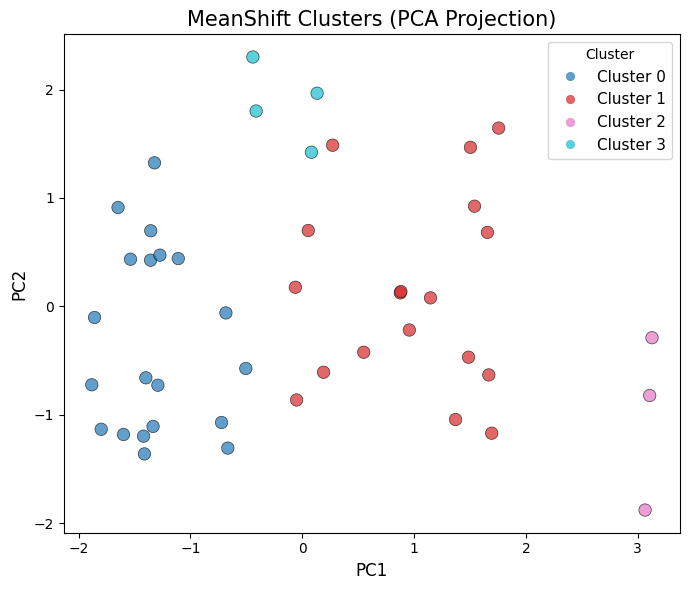

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(7, 6))
scatter = ax.scatter(
    proj[:, 0], proj[:, 1], c=labels, cmap='tab10', alpha=0.7, s=80, edgecolor='k', linewidth=0.5
)
ax.set_title('MeanShift Clusters (PCA Projection)', fontsize=15)
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)

# Improved legend: cluster numbers (not color indices)
handles, legend_labels = scatter.legend_elements(prop="colors")
legend_labels = [f"Cluster {i}" for i in np.unique(labels)]
ax.legend(handles, legend_labels, title="Cluster", loc='best', fontsize=11)

plt.tight_layout()
plt.show()


#### Output: Mean-Shift Clusters in PCA Space

This scatter plot displays cluster assignments in a reduced 2D space.  
- **Well-separated clusters** indicate strong, interpretable groupings.
- Overlap suggests possible substructure or transitional stores.

### Cluster Profile

Next, we summarize each Mean-Shift cluster by store count and the average of each feature, formatted for easy comparison.


In [38]:
# Profile clusters
clean['cluster'] = labels

profiles = (
    clean
    .groupby('cluster')
    .agg(
        count=('Store', 'count'),
        avg_sales=('avg_sales', 'mean'),
        avg_fuel=('avg_fuel', 'mean'),
        avg_CPI=('avg_CPI', 'mean'),
        avg_unemp=('avg_unemp', 'mean')
    )
    .reset_index()
)

print('Cluster Profiles:')

def format_sales(val):
    val = float(val)
    if val >= 1_000_000:
        return f"${val/1_000_000:.2f}M"
    elif val >= 1_000:
        return f"${val/1_000:.0f}K"
    else:
        return f"${val:,.0f}"

profiles_display = profiles.copy()
profiles_display['avg_sales'] = profiles_display['avg_sales'].apply(format_sales)
profiles_display['avg_fuel'] = profiles_display['avg_fuel'].round(2)
profiles_display['avg_CPI'] = profiles_display['avg_CPI'].round(1)
profiles_display['avg_unemp'] = profiles_display['avg_unemp'].round(1)

display(profiles_display[['cluster', 'count', 'avg_sales', 'avg_fuel', 'avg_CPI', 'avg_unemp']])

Cluster Profiles:


,cluster,count,avg_sales,avg_fuel,avg_CPI,avg_unemp
0,0,20,$919K,3.23,211.3,7.5
1,1,18,$1.02M,3.46,139.3,8.1
2,2,3,$906K,3.61,128.7,13.1
3,3,4,$1.90M,3.34,150.4,6.3


#### Output: Mean-Shift Cluster Profiles

- **Cluster**: Cluster number assigned by Mean-Shift.
- **Count**: Number of stores in each cluster.
- **Avg Sales**: Average weekly sales (formatted for readability).
- **Avg Fuel, CPI, Unemployment**: Economic context for each group.

These profiles are useful for targeting business strategies to each segment.

### Interpretation: K-Means vs. Mean-Shift Clustering

Both K-Means and Mean-Shift algorithms partition stores based on sales and economic features, but they approach the problem differently:

#### K-Means Clustering:
- **Requires pre-specifying the number of clusters (k).**
- **Finds clusters of roughly similar size** and is best when clusters are spherical and evenly distributed.
- **Actionability:** Useful for standard segmentation (e.g., "Top", "Middle", "Vulnerable" stores) and scenario analysis.

#### Mean-Shift Clustering:
- **Automatically determines the number of clusters** based on underlying data density.
- **Can detect clusters of varying sizes and shapes,** especially if the data distribution is non-uniform.
- **Actionability:** Reveals "natural" groupings that may highlight previously unnoticed store segments (e.g., outlier high-performers or small specialized groups).

### Comparing Results:
- **Cluster Counts:** Mean-Shift may yield more or fewer clusters than K-Means, depending on the density structure.
- **Cluster Profiles:** Some clusters may overlap with those found by K-Means, but others may isolate niche or transitional store types.
- **Business Strategy:** Use insights from both methods for robust decision-making—K-Means for consistency and tracking, Mean-Shift for uncovering hidden opportunities or risks.

- **Cluster 0:**  
  - *Profile:* [Summarize key features, e.g., moderate sales, high CPI]  
  - *Action:* Targeted marketing in high-cost areas, adapt product mix to local preferences.

- **Cluster 1:**  
  - *Profile:* [Summarize key features, e.g., high sales, low unemployment]  
  - *Action:* Maintain premium positioning, pilot new product launches, leverage local economic stability.

- **Cluster 2:**  
  - *Profile:* [Summarize key features, e.g., low sales, high fuel prices]  
  - *Action:* Increase cost-efficiency, focus on promotions tied to fuel price fluctuations.

- **Cluster 3:**  
  - *Profile:* [Summarize key features, e.g., small group, unique combination of metrics]  
  - *Action:* Investigate further—these may be special cases worth deeper qualitative analysis.


### Conclusion

This expanded implementation introduces Mean-Shift clustering, which **automatically determines the optimal number of clusters** based on the data distribution. By profiling stores according to these naturally emerging clusters, we obtain a complementary segmentation to the K-Means approach—without altering any of the prior analyses.

**Key Benefits:**
- No need to pre-specify the number of clusters.
- Clusters reflect true density patterns in the data.
- Store profiles are directly comparable to those found via K-Means, supporting robust segmentation and deeper business insight.
